In [2]:
from statsmodels.tsa.arima_process import ArmaProcess
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
def mean_model(X, v, b0=0, c0=0, c1=0):
    # Here, v should be v_rep of dimension N. 
    mu = np.exp(
        c0*np.cos(X[:,0]) + c0*np.cos(X[:,1]) + c0*np.cos(X[:,2])
        + c1/(X[:,3]**2+1) + + c1/(X[:,4]**2+1)
        + b0 + v
    )
    return mu

In [4]:
def generate_data(
    data_type, dir_name,
    b0 = 0.2, c0 = 0.2, c1 = 0.2,
    p = 10, # related p = 5 and others are unrelated
    ar = [1, -0.5],
    ma = 1,
    n_simul = 100
):
    
    n_sub, n_num, lam, rand_dist = data_type.split('-')
    n_sub, n_num, lam = int(n_sub), int(n_num), float(lam)
    N = n_sub * n_num
    n_new = n_sub    
    arma = ArmaProcess(ar, ma) # AR(1) with coeff 0.5
    
    settings = np.column_stack([n_simul, n_sub, n_num, n_new, p, b0, lam])
    colnames = ['n_simul','n_sub', 'n_num', 'n_new','p', 'b0', 'lam']
    settings = pd.DataFrame(settings, columns=colnames)
    settings.to_csv(dir_name + 'simul-settings-' + data_type + '.csv', index=False)
    
    for repeat in range(n_simul):

        # Generate data

        np.random.seed(repeat)
        X = arma.generate_sample(nsample=(N,p), axis=1)
        if rand_dist == 'fixed':
            u_rep, v_rep = np.repeat(1, N), np.repeat(0, N)
        elif rand_dist == 'gamma':
            u = np.random.gamma(1/lam, lam, n_sub)
            u_rep = np.repeat(u, n_num)
            v_rep = np.log(u_rep)
        elif rand_dist == 'expo':
            u = np.random.exponential(np.sqrt(lam), n_sub) # mean = sqrt(lam), var = lam
            u_rep = np.repeat(u, n_num)
            v_rep = np.log(u_rep)
        elif rand_dist == 'logN':
            v = np.random.normal(0, np.sqrt(lam), n_sub)
            u = np.exp(v)
            u_rep = np.repeat(u, n_num)
            v_rep = np.repeat(v, n_num)
        else:
            print("rand_dist is wrong !!!")
            
        mu = mean_model(X, v_rep, b0, c0, c1)
        y = np.random.poisson(mu)

        data = pd.DataFrame(X, columns=[('x'+str(i)) for i in range(p)])
        data['y'] = y
        data['u'] = u_rep
        data['mu'] = mu
        data['sub'] = np.repeat(np.arange(n_sub), n_num)
        data['num'] = np.tile(np.arange(n_num), n_sub)

        # new subjects

        np.random.seed(repeat+n_simul)
        
        X_new = arma.generate_sample(nsample=(n_new,p), axis=1)
        if rand_dist == 'fixed':
            u_new, v_new = np.repeat(1, n_new), np.repeat(0, n_new)
        elif rand_dist == 'gamma':
            u_new = np.random.gamma(1/lam, lam, n_new)
            v_new = np.log(u_new)
        elif rand_dist == 'expo':
            u_new = np.random.exponential(np.sqrt(lam), n_new) # mean = sqrt(lam), var = lam
            v_new = np.log(u_new)
        elif rand_dist == 'logN':
            v_new = np.random.normal(0, np.sqrt(lam), n_new)
            u_new = np.exp(v_new)
        
        mu_new = mean_model(X_new, v_new, b0, c0, c1)
        y_new = np.random.poisson(mu_new)

        data_new = pd.DataFrame(X_new, columns=[('x'+str(i)) for i in range(p)])
        data_new['y'] = y_new
        data_new['u'] = u_new
        data_new['mu'] = mu_new
        data_new['sub'] = np.arange(n_sub, n_sub+n_new)
        data_new['num'] = np.tile(1, n_new)
        
        # save data

        file_name = dir_name + 'simul-data-' + data_type + '-' + str(repeat)
        data.to_csv(file_name+'.csv', index=False)
        data_new.to_csv(file_name+'-new.csv', index=False)
        
        sns.countplot(x='y', data=data)

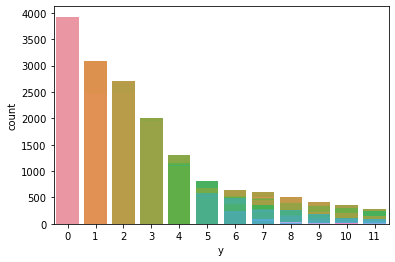

In [5]:
dir_name = 'C:/Users/hangbin/Google Drive/_New/Research/DeepHGLM/Simulation/data/'
data_type_list = [
    '1000-10-0-fixed', '100-100-0-fixed', '20-500-0-fixed',
    '1000-10-0.5-gamma', '100-100-0.5-gamma', '20-500-0.5-gamma',
    '1000-10-2-gamma', '100-100-2-gamma', '20-500-2-gamma', 
    '1000-10-0.5-logN','100-100-0.5-logN','20-500-0.5-logN',
    '1000-10-2-logN',  '100-100-2-logN',  '20-500-2-logN'
]

for data_type in data_type_list:    
    generate_data(
        data_type,
        dir_name,
        b0 = 0.2, c0 = 0.2, c1 = 0.2,
        p = 10, # related p = 5 and others are unrelated
        ar = [1, -0.5],
        ma = 1,
        n_simul = 100)